In [1]:
import string, re, json, pickle, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_preparation import take_a_shower, clean_content_aravec
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<AxesSubplot:xlabel='is_off', ylabel='count'>

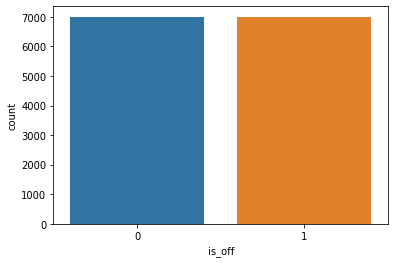

In [4]:
sns.countplot(x='is_off', data=data)

In [5]:
data.Comment = data.Comment.apply(take_a_shower)
data.shape

(14000, 2)

In [6]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional,Input, Activation, Dropout, Dense,GlobalAveragePooling1D,GlobalMaxPooling1D, SpatialDropout1D, GlobalMaxPool1D
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l1,l2

In [7]:
# load data
x = data.Comment.values
y = data.is_off.values
MAX_TEXT_LENGTH = get_max_length(x)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Dataset splited.')
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))
print("Max Length: " + str(MAX_TEXT_LENGTH))

Dataset splited.
Label categories: [0 1]
Max Length: 461


In [51]:
MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

In [52]:
x_train, x_test, y_train, y_test, word_index = class_str_2_ind(X_train, 
                                                               X_test, 
                                                               Y_train, Y_test,
                                                               CLASSES_LIST, MAX_NB_WORDS,
                                                               MAX_SEQUENCE_LENGTH)
print('Found %d unique words.' % len(word_index))

Converting data to trainable form...
Number of training examples: 11200
Number of testing examples: 2800
Found 44530 unique words.


number of target in train set: 11200
number of samplse offensive class: 5584
number of samplse non-offensive class: 5616


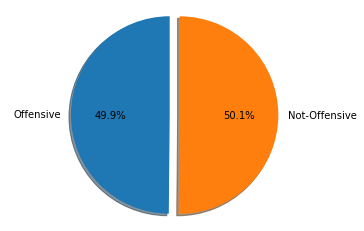

In [53]:
print('number of target in train set: {}'.format(len(y_train)))
print('number of samplse offensive class: {}'.format(sum(y_train)))
print('number of samplse non-offensive class: {}'.format(len(y_train)-sum(y_train)))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Offensive', 'Not-Offensive'
sizes = [sum(y_train), len(y_train)-sum(y_train)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

number of target in test set: 2800
number of samplse offensive class: 1416
number of samplse non-offensive class: 1384


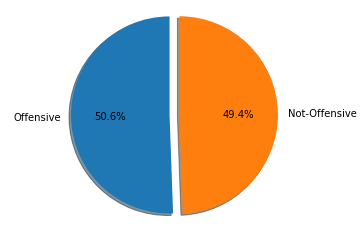

In [54]:
print('number of target in test set: {}'.format(len(y_test)))
print('number of samplse offensive class: {}'.format(sum(y_test)))
print('number of samplse non-offensive class: {}'.format(len(y_test)-sum(y_test)))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Offensive', 'Not-Offensive'
sizes = [sum(y_test), len(y_test)-sum(y_test)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# LSTM

In [55]:
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(8, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          200000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 8)            3488      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1152      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)               

In [57]:
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history, lstm_model = train_fit(model, x_train, y_train, 64, 5)

Epoch 1/5
140/140 [==============================] - 28s 201ms/step - loss: 0.6853 - accuracy: 0.5407 - val_loss: 0.6114 - val_accuracy: 0.7018
Epoch 2/5
140/140 [==============================] - 28s 198ms/step - loss: 0.5165 - accuracy: 0.7627 - val_loss: 0.4755 - val_accuracy: 0.7759
Epoch 3/5
140/140 [==============================] - 28s 199ms/step - loss: 0.3998 - accuracy: 0.8278 - val_loss: 0.4856 - val_accuracy: 0.7692
Epoch 4/5
140/140 [==============================] - 28s 198ms/step - loss: 0.3675 - accuracy: 0.8434 - val_loss: 0.4894 - val_accuracy: 0.7674
Epoch 5/5
140/140 [==============================] - 28s 199ms/step - loss: 0.3482 - accuracy: 0.8584 - val_loss: 0.5064 - val_accuracy: 0.7692


In [58]:
accuracy, accuracy_val = evaluate_model(model, x_train, y_train, x_test, y_test)

350/350 [==============================] - 13s 36ms/step - loss: 0.3277 - accuracy: 0.8594
Training Accuracy: 0.8594
Training Loss: 0.3277
88/88 [==============================] - 3s 37ms/step - loss: 0.4740 - accuracy: 0.7832
Testing Accuracy:  0.7832
Testing Loss:  0.4740


In [59]:
print(classification_report(y_test, get_prediction(model, x_test)))

88/88 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1384
           1       0.79      0.77      0.78      1416

    accuracy                           0.78      2800
   macro avg       0.78      0.78      0.78      2800
weighted avg       0.78      0.78      0.78      2800



Optimal epoch : 1
Accuracy on train : 76.27 %
Accuracy on test : 77.59 %
Loss on train : 51.65
Loss on test : 47.55


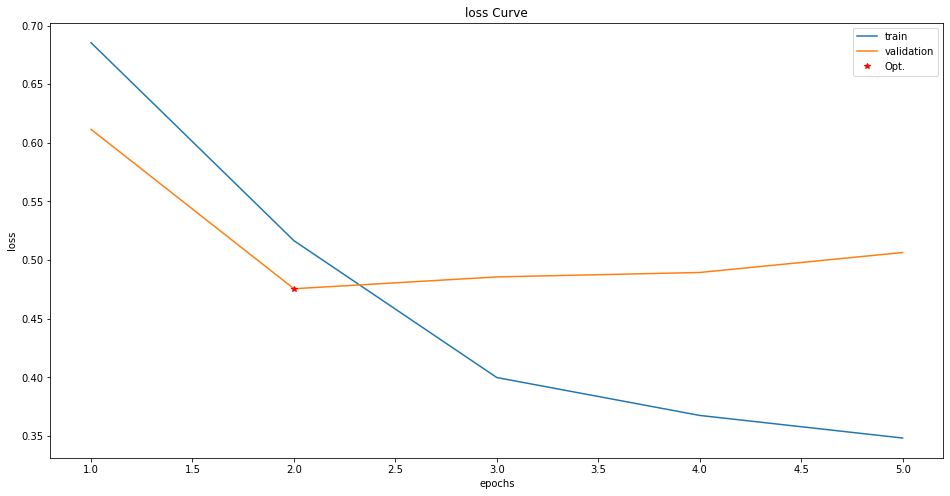

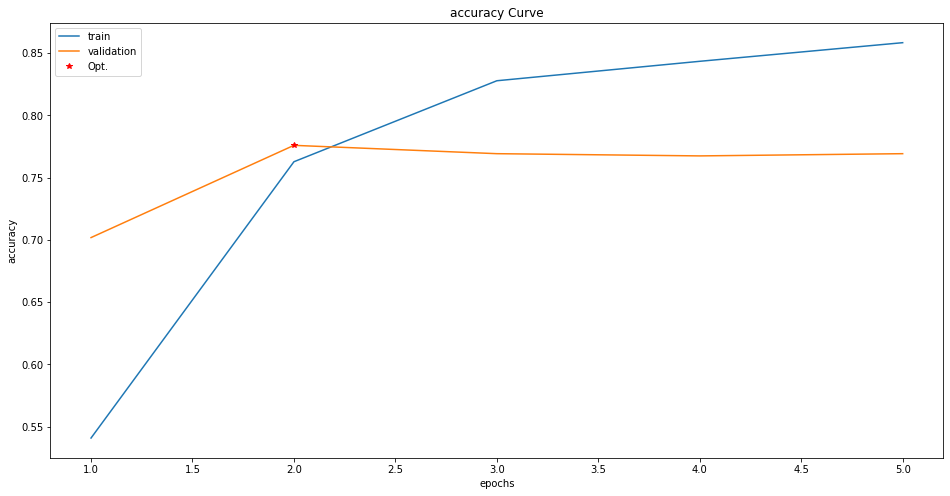

In [60]:
n = get_optimal_epoch(history)
#train loss vs validation loss
show_train_history(history,'loss','val_loss', n)
show_train_history(history,'accuracy','val_accuracy', n)

In [61]:
df_test = model_analyse(model, x_test, X_test, y_test)
df_test[df_test.REAL != df_test.PRED]

88/88 [==============================] - 3s 36ms/step
Number of misclassified reviews: 607 out of 2800
Blind Test Accuracy:  0.7832


,REAL,PRED,TEXT
6,1,0.0,جبهه النصره تعرف القاعده مربط الجمل
7,0,1.0,اتحدي النظام يفعل اللحظه <NUM> الامام
15,0,1.0,عطاتكم الايام لخلاص الاخر ربي كبير
17,0,1.0,اللهم دير تݣزارت النجاره هاد الشوهه داير الله ...
18,1,0.0,اعتقد الاحتلال الاسراءلي ضلع
...,...,...,...
2792,1,0.0,وقتل <NUM> سعوديا الحدود برصاص القبايل <NUM> م...
2793,1,0.0,كيانك نتيجه استفتاء لتبارك للاسبانيا فتحها الع...
2794,0,1.0,انا شايف انو رغم عدوانيه هالقرار مازلنا مصرين ...
2796,1,0.0,كيتلوا بحال لفعه الله يعطك دقه جدي طاح ناد


In [40]:
save_model(model, 'lstm', 'lstm', round(accuracy_val, 4))

Model Saved Successfully in ./models/lstm/ as lstm_acc_0.7864


# BiLSTM

In [77]:
bimodel = Sequential()
bimodel.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
bimodel.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
bimodel.add(GlobalMaxPool1D())
bimodel.add(Dense(128, activation='relu'))
bimodel.add(Dropout(0.5))
bimodel.add(Dense(64, activation='relu'))
bimodel.add(Dropout(0.5))
bimodel.add(Dense(32, activation='relu'))
bimodel.add(Dropout(0.5))
bimodel.add(Dense(1, activation='sigmoid'))
bimodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
print(bimodel.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          200000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 200)          160800    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)               

In [78]:
history, bilstm_model = train_fit(bimodel, x_train, y_train, 64, 5)

Epoch 1/5
140/140 [==============================] - 76s 545ms/step - loss: 0.6770 - accuracy: 0.5618 - val_loss: 0.5828 - val_accuracy: 0.7018
Epoch 2/5
140/140 [==============================] - 74s 531ms/step - loss: 0.5021 - accuracy: 0.7724 - val_loss: 0.4645 - val_accuracy: 0.7754
Epoch 3/5
140/140 [==============================] - 77s 550ms/step - loss: 0.3950 - accuracy: 0.8326 - val_loss: 0.4925 - val_accuracy: 0.7683
Epoch 4/5
140/140 [==============================] - 72s 514ms/step - loss: 0.3597 - accuracy: 0.8467 - val_loss: 0.5237 - val_accuracy: 0.7683
Epoch 5/5
140/140 [==============================] - 73s 520ms/step - loss: 0.3249 - accuracy: 0.8610 - val_loss: 0.5858 - val_accuracy: 0.7674


In [83]:
accuracy, accuracy_val = evaluate_model(model, x_train, y_train, x_test, y_test)

350/350 [==============================] - 13s 36ms/step - loss: 0.3277 - accuracy: 0.8594
Training Accuracy: 0.8594
Training Loss: 0.3277
88/88 [==============================] - 3s 37ms/step - loss: 0.4740 - accuracy: 0.7832
Testing Accuracy:  0.7832
Testing Loss:  0.4740


In [84]:
print(classification_report(y_test, get_prediction(model, x_test)))

88/88 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1384
           1       0.79      0.77      0.78      1416

    accuracy                           0.78      2800
   macro avg       0.78      0.78      0.78      2800
weighted avg       0.78      0.78      0.78      2800



In [85]:
n = get_optimal_epoch(history)

Optimal epoch : 1
Accuracy on train : 77.24 %
Accuracy on test : 77.54 %
Loss on train : 50.21
Loss on test : 46.45


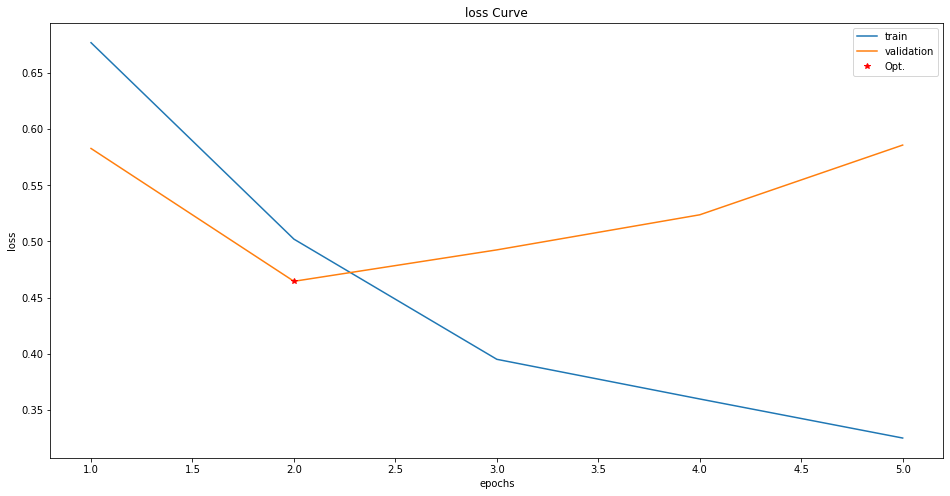

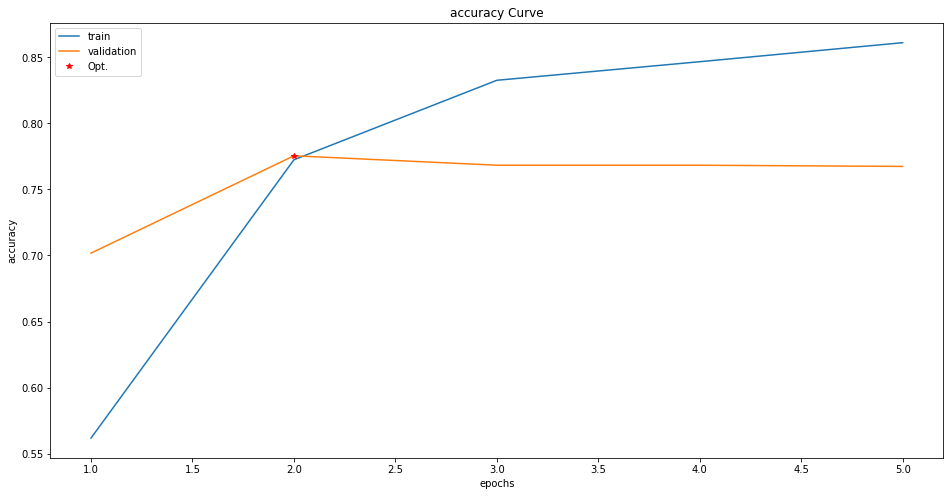

In [86]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss', n)
show_train_history(history,'accuracy','val_accuracy', n)

In [87]:
save_model(model, 'lstm', 'bilstm', round(accuracy_val, 4))

Model Saved Successfully in ./models/lstm/ as bilstm_acc_0.7832
